In [1]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
from sigfig import round
from collections import defaultdict
from os.path import dirname, abspath
from IPython.display import display

%matplotlib inline
warnings.filterwarnings('ignore')


Bad key "text.kerning_factor" on line 4 in
/Users/yamauchi/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def get_samesubject_sampleids(mdf, mkey, mvals, msk="subject_id", axis=1, return_subjectid=False):
    def query_col(df, key, val):
        return df.loc[:, df.loc[key, :] == val]

    m = "metadata table is not unique by -mk and -msk"
    subject_ids = sorted(set(mdf.loc[msk, :]))
    sample_ids = []
    for mval in mvals:
        _sample_ids = []
        for subject_id in subject_ids:
            mdf_ext_step1 = query_col(mdf, msk, subject_id)
            mdf_ext_step2 = query_col(mdf_ext_step1, mkey, mval)
            if mdf_ext_step2.shape[1] != 1:
                raise ValueError(m)
            _sample_ids.append(mdf_ext_step2.columns[0])
        sample_ids.append(_sample_ids)

    if return_subjectid and axis == 1:
        return sample_ids, subject_ids
    elif not return_subjectid and axis == 1:
        return sample_ids
    elif return_subjectid and axis == 0:
        return [list(x) for x in zip(*sample_ids)], subject_ids
    elif not return_subjectid and axis == 0:
        return [list(x) for x in zip(*sample_ids)]


def make_effsize_df(df, mdf, mkey, mvals, pattern_responder_score):
    (sampleids_ctrl, sampleids_test), subject_ids = get_samesubject_sampleids(mdf, mkey, mvals, return_subjectid=True)
    dd = defaultdict(lambda: defaultdict(int))
    for ind in df.index:
        for sampleid_ctrl, sampleid_test, subject_id in zip(sampleids_ctrl, sampleids_test, subject_ids):
            ctrl = df.loc[ind, sampleid_ctrl]
            test = df.loc[ind, sampleid_test]
            if pattern_responder_score == 1:
                effsize = test - ctrl
            elif pattern_responder_score == 2:
                effsize = (test - ctrl) / ctrl
            else:
                raise ValueError()
            dd[subject_id][ind] = effsize
    return pd.DataFrame(dd)


def fill_inf(s):
    if s.isnull().any():
        raise ValueError("isnull.any")
    s = s.replace(np.inf, np.nan)
    s = s.fillna(s.max())
    s = s.replace(-np.inf, np.nan)
    s = s.fillna(s.min())
    return s


def dropna_paired(vals1, vals2):
    new_vals1 = []
    new_vals2 = []
    for val1, val2 in zip(vals1, vals2):
        if not np.isnan(val1) and not np.isnan(val2):
            new_vals1.append(val1)
            new_vals2.append(val2)
    return new_vals1, new_vals2

In [3]:
ge = pd.read_csv("../data_input/ge.tsv", sep="\t", header=0, index_col=0)
ra = pd.read_csv("../data_input/ra.tsv", sep="\t", header=0, index_col=0)
co = pd.read_csv("../data_input/scfa.abs.tsv", sep="\t", header=0, index_col=0)
nm = pd.read_csv("../data_input/nm.tsv", sep="\t", header=0, index_col=0)
me = pd.read_csv("../data_input/me.tsv", sep="\t", header=0, index_col=0)

ge = ge.loc[ge.mean(axis=1) >= 0.001]
ra = ra.loc[((ra > 0).sum(axis=1) / len(ra.columns)) >= 0.25]
ra.drop(ra.loc[ra.index.str.contains("\n")].index, inplace=True)
ra.drop(ra.loc[ra.index.str.startswith("XA")].index, inplace=True)
ra.drop(ra.loc[ra.index.str.startswith("XC")].index, inplace=True)

In [4]:
df_all = pd.concat([ge, ra, nm])

In [5]:
def make_responder_table(mkey, mvals, ge, ra, nm, me, dk, group):
    ge_GP = ge.loc[:, me.loc["group"]==group]
    ra_GP = ra.loc[:, me.loc["group"]==group]
    nm_GP = nm.loc[:, me.loc["group"]==group]
    me_GP = me.loc[:, me.loc["group"]==group]    

    pattern_responder_score = 2

    ge_eff = make_effsize_df(ge_GP, me_GP, mkey, mvals, pattern_responder_score).fillna(0)
    ra_eff = make_effsize_df(ra_GP, me_GP, mkey, mvals, pattern_responder_score).fillna(0)
    nm_eff = make_effsize_df(nm_GP, me_GP, mkey, mvals, pattern_responder_score).fillna(0)

    eff_all = pd.concat([ge_eff, ra_eff, nm_eff])

    me_base = me_GP.T.query(f"timepoint == '0w'").T
    me_eff = me_base.copy()
    me_eff.columns = me_eff.loc["subject_id", :]

    # baselineの抽出
    ge_base = ge_GP.loc[:, me_base.columns]
    ra_base = ra_GP.loc[:, me_base.columns]
    nm_base = nm_GP.loc[:, me_base.columns]

    # ベースライン
    dd = defaultdict(lambda: defaultdict(int))
    base = pd.concat([ge_base, ra_base, nm_base]).T
    _base = base.copy()
    _base.index = [me_GP.loc["subject_id", sample_id] for sample_id in _base.index]
    for col in _base.columns:
        x = _base.loc[_base.index, col]
        y = eff_all.loc[dk, _base.index]
        x = fill_inf(x)
        y = fill_inf(y)
        per, pep = st.pearsonr(x, y)
        spr, spp = st.spearmanr(x, y)
        dd[col]["PearsonR_base"] = per
        dd[col]["PearsonP_base"] = pep
        dd[col]["SpearmanR_base"] = spr
        dd[col]["SpearmanP_base"] = spp
    responder_base_GP = pd.DataFrame(dd).T

    # 変化量
    dd = defaultdict(lambda: defaultdict(int))
    eff = eff_all.T
    for col in eff.columns:
        x = eff[col]
        y = eff[dk]
        x = fill_inf(x)
        y = fill_inf(y)
        per, pep = st.pearsonr(x, y)
        spr, spp = st.spearmanr(x, y)
        dd[col]["PearsonR_eff"] = per
        dd[col]["PearsonP_eff"] = pep
        dd[col]["SpearmanR_eff"] = spr
        dd[col]["SpearmanP_eff"] = spp
    responder_eff_GP = pd.DataFrame(dd).T
    
    return responder_base_GP, responder_eff_GP

In [6]:
resp_IgA_C_base, resp_IgA_C_eff = make_responder_table("timepoint", ["0w", "4w"], ge, ra, nm, me,"IgA", "C")
resp_IgA_T_base, resp_IgA_T_eff = make_responder_table("timepoint", ["0w", "4w"], ge, ra, nm, me,"IgA", "T")
resp_Acetate_C_base, resp_Acetate_C_eff = make_responder_table("timepoint", ["0w", "4w"], ge, co, nm, me,"Acetate", "C")
resp_Acetate_T_base, resp_Acetate_T_eff = make_responder_table("timepoint", ["0w", "4w"], ge, co, nm, me,"Acetate", "T")
resp_Propionate_C_base, resp_Propionate_C_eff = make_responder_table("timepoint", ["0w", "4w"], ge, ra, nm, me,"Propionic acid", "C")
resp_Propionate_T_base, resp_Propionate_T_eff = make_responder_table("timepoint", ["0w", "4w"], ge, ra, nm, me,"Propionic acid", "T")
resp_Butyrate_C_base, resp_Butyrate_C_eff = make_responder_table("timepoint", ["0w", "4w"], ge, ra, nm, me,"Butyric acid", "C")
resp_Butyrate_T_base, resp_Butyrate_T_eff = make_responder_table("timepoint", ["0w", "4w"], ge, ra, nm, me,"Butyric acid", "T")
resp_Succinate_C_base, resp_Succinate_C_eff = make_responder_table("timepoint", ["0w", "4w"], ge, ra, nm, me,"Succinic acid", "C")
resp_Succinate_T_base, resp_Succinate_T_eff = make_responder_table("timepoint", ["0w", "4w"], ge, ra, nm, me,"Succinic acid", "T")

In [7]:
!mkdir -p ../data_output/responder

In [8]:
resp_IgA_C_base.to_csv("../data_output/responder/responder.IgA_C_base.tsv", sep="\t")
resp_IgA_C_eff.to_csv("../data_output/responder/responder.IgA_C_eff.tsv", sep="\t")
resp_IgA_T_base.to_csv("../data_output/responder/responder.IgA_T_base.tsv", sep="\t")
resp_IgA_T_eff.to_csv("../data_output/responder/responder.IgA_T_eff.tsv", sep="\t")
resp_Acetate_C_base.to_csv("../data_output/responder/responder.Acetate_C_base.tsv", sep="\t")
resp_Acetate_C_eff.to_csv("../data_output/responder/responder.Acetate_C_eff.tsv", sep="\t")
resp_Acetate_T_base.to_csv("../data_output/responder/responder.Acetate_T_base.tsv", sep="\t")
resp_Acetate_T_eff.to_csv("../data_output/responder/responder.Acetate_T_eff.tsv", sep="\t")
resp_Propionate_C_base.to_csv("../data_output/responder/responder.Propionate_C_base.tsv", sep="\t")
resp_Propionate_C_eff.to_csv("../data_output/responder/responder.Propionate_C_eff.tsv", sep="\t")
resp_Propionate_T_base.to_csv("../data_output/responder/responder.Propionate_T_base.tsv", sep="\t")
resp_Propionate_T_eff.to_csv("../data_output/responder/responder.Propionate_T_eff.tsv", sep="\t")
resp_Butyrate_C_base.to_csv("../data_output/responder/responder.Butyrate_C_base.tsv", sep="\t")
resp_Butyrate_C_eff.to_csv("../data_output/responder/responder.Butyrate_C_eff.tsv", sep="\t")
resp_Butyrate_T_base.to_csv("../data_output/responder/responder.Butyrate_T_base.tsv", sep="\t")
resp_Butyrate_T_eff.to_csv("../data_output/responder/responder.Butyrate_T_eff.tsv", sep="\t")
resp_Succinate_C_base.to_csv("../data_output/responder/responder.Succinate_C_base.tsv", sep="\t")
resp_Succinate_C_eff.to_csv("../data_output/responder/responder.Succinate_C_eff.tsv", sep="\t")
resp_Succinate_T_base.to_csv("../data_output/responder/responder.Succinate_T_base.tsv", sep="\t")
resp_Succinate_T_eff.to_csv("../data_output/responder/responder.Succinate_T_eff.tsv", sep="\t")

In [13]:
def draw_heatmap_1(df_base_C, df_base_T, df_eff_C, df_eff_T, ref, dk):
    responder_eff = pd.DataFrame(columns=["CF_R", "CF_p", "FG_R", "FG_p"])

    for ind in ref.index:
        if ind == dk:
            continue
    #     if (responder_eff_C.loc[ind, "SpearmanP_eff"] < 0.05) or (responder_eff_T.loc[ind, "SpearmanP_eff"] < 0.05):
        if ((df_eff_C.loc[ind, "PearsonP_eff"] < 0.1) and (df_eff_C.loc[ind, "SpearmanP_eff"] < 0.05)) or ((df_eff_T.loc[ind, "PearsonP_eff"] < 0.1) and (df_eff_T.loc[ind, "SpearmanP_eff"] < 0.05)):
            responder_eff.loc[ind, "CF_R"] = df_eff_C.loc[ind, "SpearmanR_eff"]
            responder_eff.loc[ind, "CF_p"] = df_eff_C.loc[ind, "SpearmanP_eff"]
            responder_eff.loc[ind, "FG_R"] = df_eff_T.loc[ind, "SpearmanR_eff"]
            responder_eff.loc[ind, "FG_p"] = df_eff_T.loc[ind, "SpearmanP_eff"]

    responder_base = pd.DataFrame(columns=["CF_R", "CF_p", "FG_R", "FG_p"])

    for ind in ref.index:
        if ind == dk:
            continue
    #     if (responder_base_C.loc[ind, "SpearmanP_base"] < 0.05) or (responder_base_T.loc[ind, "SpearmanP_base"] < 0.05):
        if ((df_base_C.loc[ind, "PearsonP_base"] < 0.1) and (df_base_C.loc[ind, "SpearmanP_base"] < 0.05)) or ((df_base_T.loc[ind, "PearsonP_base"] < 0.1) and (df_base_T.loc[ind, "SpearmanP_base"] < 0.05)):
            responder_base.loc[ind, "CF_R"] = df_base_C.loc[ind, "SpearmanR_base"]
            responder_base.loc[ind, "CF_p"] = df_base_C.loc[ind, "SpearmanP_base"]
            responder_base.loc[ind, "FG_R"] = df_base_T.loc[ind, "SpearmanR_base"]
            responder_base.loc[ind, "FG_p"] = df_base_T.loc[ind, "SpearmanP_base"]
            
    plt.figure(figsize=(3, 1*len(responder_base.index)))
    sns.heatmap(responder_base[["CF_R", "FG_R"]].astype(float), cmap="coolwarm", vmax=.5, vmin=-.5, annot=True, xticklabels=["CF", "FG"])
    plt.savefig(f"heatmap.responder.{dk}.baseline.pdf", bbox_inches="tight")
    plt.show()
    
    plt.figure(figsize=(2, 0.4*len(responder_eff.index)))
    sns.heatmap(responder_eff[["CF_R", "FG_R"]].astype(float), cmap="coolwarm", vmax=.5, vmin=-.5, annot=True, xticklabels=["CF", "FG"])
    plt.savefig(f"heatmap.responder.{dk}.eff.pdf", bbox_inches="tight")
    plt.show()

In [10]:
def draw_heatmap_2(df_base_C, df_base_T, df_eff_C, df_eff_T, ref, dk):
    responder_eff = pd.DataFrame(columns=["CF_R", "CF_p", "FG_R", "FG_p"])

    for ind in ref.index:
        if ind == dk:
            continue
#         if (df_eff_C.loc[ind, "SpearmanP_eff"] < 0.05) or (df_eff_T.loc[ind, "SpearmanP_eff"] < 0.05):
        if ((df_eff_C.loc[ind, "PearsonP_eff"] < 0.1) and (df_eff_C.loc[ind, "SpearmanP_eff"] < 0.05)) or ((df_eff_T.loc[ind, "PearsonP_eff"] < 0.1) and (df_eff_T.loc[ind, "SpearmanP_eff"] < 0.05)):
            responder_eff.loc[ind, "CF_R"] = df_eff_C.loc[ind, "SpearmanR_eff"]
            responder_eff.loc[ind, "CF_p"] = df_eff_C.loc[ind, "SpearmanP_eff"]
            responder_eff.loc[ind, "FG_R"] = df_eff_T.loc[ind, "SpearmanR_eff"]
            responder_eff.loc[ind, "FG_p"] = df_eff_T.loc[ind, "SpearmanP_eff"]

    responder_base = pd.DataFrame(columns=["CF_R", "CF_p", "FG_R", "FG_p"])

    for ind in ref.index:
        if ind == dk:
            continue
#         if (df_base_C.loc[ind, "SpearmanP_base"] < 0.05) or (df_base_T.loc[ind, "SpearmanP_base"] < 0.05):
        if ((df_base_C.loc[ind, "PearsonP_base"] < 0.1) and (df_base_C.loc[ind, "SpearmanP_base"] < 0.05)) or ((df_base_T.loc[ind, "PearsonP_base"] < 0.1) and (df_base_T.loc[ind, "SpearmanP_base"] < 0.05)):
            responder_base.loc[ind, "CF_R"] = df_base_C.loc[ind, "SpearmanR_base"]
            responder_base.loc[ind, "CF_p"] = df_base_C.loc[ind, "SpearmanP_base"]
            responder_base.loc[ind, "FG_R"] = df_base_T.loc[ind, "SpearmanR_base"]
            responder_base.loc[ind, "FG_p"] = df_base_T.loc[ind, "SpearmanP_base"]
            
    plt.figure(figsize=(2, 0.4*len(responder_base.index)))
    sns.heatmap(responder_base[["CF_R", "FG_R"]].astype(float), cmap="coolwarm", vmax=.5, vmin=-.5, annot=True, xticklabels=["CF", "FG"])
    plt.savefig(f"heatmap.responder.{dk}.baseline.pdf", bbox_inches="tight")
    plt.show()
    
    plt.figure(figsize=(2, 0.4*len(responder_eff.index)))
    sns.heatmap(responder_eff[["CF_R", "FG_R"]].astype(float), cmap="coolwarm", vmax=.5, vmin=-.5, annot=True, xticklabels=["CF", "FG"])
    plt.savefig(f"heatmap.responder.{dk}.eff.pdf", bbox_inches="tight")
    plt.show()

In [11]:
plt.rcParams["font.family"] = "Arial"

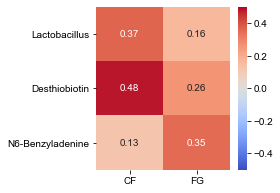

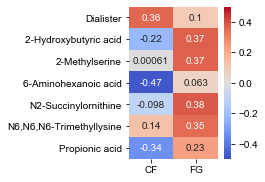

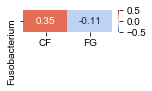

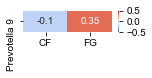

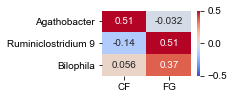

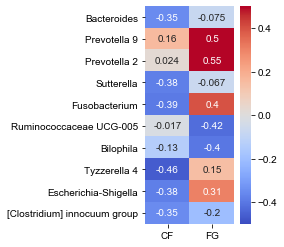

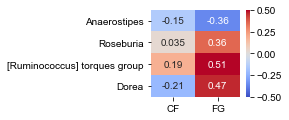

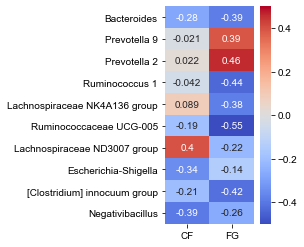

In [14]:
draw_heatmap_1(resp_IgA_C_base, resp_IgA_T_base, resp_IgA_C_eff, resp_IgA_T_eff, pd.concat([ge, ra]), "IgA")
draw_heatmap_2(resp_Acetate_C_base, resp_Acetate_T_base, resp_Acetate_C_eff, resp_Acetate_T_eff, ge, "Acetate")
draw_heatmap_2(resp_Propionate_C_base, resp_Propionate_T_base, resp_Propionate_C_eff, resp_Propionate_T_eff, ge, "Propionic acid")
draw_heatmap_2(resp_Butyrate_C_base, resp_Butyrate_T_base, resp_Butyrate_C_eff, resp_Butyrate_T_eff, ge, "Butyric acid")

In [150]:
def pval_table(df_eff_C, df_eff_T, ref, dk):
    responder_eff = pd.DataFrame(columns=["CF_p", "FG_p"])

    for ind in ref.index:
        if ind == dk:
            continue
        if ((df_eff_C.loc[ind, "PearsonP_eff"] < 0.1) and (df_eff_C.loc[ind, "SpearmanP_eff"] < 0.05)) or ((df_eff_T.loc[ind, "PearsonP_eff"] < 0.1) and (df_eff_T.loc[ind, "SpearmanP_eff"] < 0.05)):
            responder_eff.loc[ind, "CF_p"] = df_eff_C.loc[ind, "SpearmanP_eff"]
            responder_eff.loc[ind, "FG_p"] = df_eff_T.loc[ind, "SpearmanP_eff"]
            
    return responder_eff

In [157]:
def replace_sig(df):
    for ind in df.index:
        for col in df.columns:
            _p = df.loc[ind, col]
            if _p < 0.05:
                df.loc[ind, col] = "*"
            else:
                df.loc[ind, col] = ""
    return df

In [158]:
pval_A = pval_table(resp_Acetate_C_eff, resp_Acetate_T_eff, ge, "Acetate")
pval_P = pval_table(resp_Propionate_C_eff, resp_Propionate_T_eff, ge, "Propionic acid")
pval_B = pval_table(resp_Butyrate_C_eff, resp_Butyrate_T_eff, ge, "Butyric acid")

pval_A = replace_sig(pval_A)
pval_P = replace_sig(pval_P)
pval_B = replace_sig(pval_B)

In [160]:
display(pval_A)
display(pval_P)
display(pval_B)

,CF_p,FG_p
Prevotella 9,,*


,CF_p,FG_p
Bacteroides,*,
Prevotella 9,,*
Prevotella 2,,*
Sutterella,*,
Fusobacterium,*,*
Ruminococcaceae UCG-005,,*
Bilophila,,*
Tyzzerella 4,*,
Escherichia-Shigella,*,
[Clostridium] innocuum group,*,


,CF_p,FG_p
Bacteroides,,*
Prevotella 9,,*
Prevotella 2,,*
Ruminococcus 1,,*
Lachnospiraceae NK4A136 group,,*
Ruminococcaceae UCG-005,,*
Lachnospiraceae ND3007 group,*,
Escherichia-Shigella,*,
[Clostridium] innocuum group,,*
Negativibacillus,*,


In [161]:
pval_A.to_csv("pval.Acetate.tsv", sep="\t")
pval_P.to_csv("pval.Propionate.tsv", sep="\t")
pval_B.to_csv("pval.Butyrate.tsv", sep="\t")